## Training Setup

### Setup

In [ ]:
# This mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import numpy as np
import torch
from torchvision import datasets, transforms
from torch.utils.data import random_split, DataLoader

import torch.nn as nn
import torch.optim as optim
from torch.utils.data import sampler

USE_GPU = True
dtype = torch.float32

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

# Constant to control how frequently we print training loss.
print_every = 100
print('using device:', device)

using device: cuda


### Install necessary packages

**NOTE:** To make it easier for us to manage datasets, images and models we create a `HOME` constant. 

In [ ]:
import os
HOME = os.getcwd()
print("HOME:", HOME)

HOME: /content


In [ ]:
!pip uninstall -y supervision
!pip install -q supervision==0.6.0

import supervision as sv
print(sv.__version__)

0.6.0


In [ ]:
!pip install -q roboflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.8/67.8 kB 7.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 7.3 MB/s eta 0:00:00


### Download Grounding DINO Model Weights

To run Grounding DINO we need two files - configuration and model weights. The configuration file is part of the [Grounding DINO](https://github.com/IDEA-Research/GroundingDINO) repository, which we have already cloned. The weights file, on the other hand, we need to download. We write the paths to both files to the `GROUNDING_DINO_CONFIG_PATH` and `GROUNDING_DINO_CHECKPOINT_PATH` variables and verify if the paths are correct and the files exist on disk.

In [ ]:
import os

GROUNDING_DINO_CONFIG_PATH = os.path.join(HOME, "GroundingDINO/groundingdino/config/GroundingDINO_SwinT_OGC.py")
print(GROUNDING_DINO_CONFIG_PATH, "; exist:", os.path.isfile(GROUNDING_DINO_CONFIG_PATH))

In [ ]:
%cd {HOME}
!mkdir -p {HOME}/weights
%cd {HOME}/weights

!wget -q https://github.com/IDEA-Research/GroundingDINO/releases/download/v0.1.0-alpha/groundingdino_swint_ogc.pth

In [ ]:
import os

GROUNDING_DINO_CHECKPOINT_PATH = os.path.join(HOME, "weights", "groundingdino_swint_ogc.pth")
print(GROUNDING_DINO_CHECKPOINT_PATH, "; exist:", os.path.isfile(GROUNDING_DINO_CHECKPOINT_PATH))

In [ ]:
!wget -O '/content/drive/MyDrive/cse493g1/Project_prep/garbage-classification' 'https://www.kaggle.com/datasets/mostafaabla/garbage-classification/download?datasetVersionNumber=1'
!mkdir -p {HOME}/garbage-classification
%cd {HOME}/garbage-classification

!wget -O '/content/garbage-classification' 'https://www.kaggle.com/datasets/mostafaabla/garbage-classification/download?datasetVersionNumber=1'

### Download Segment Anything Model (SAM) Weights

As with Grounding DINO, in order to run SAM we need a weights file, which we must first download. We write the path to local weight file to `SAM_CHECKPOINT_PATH` variable and verify if the path is correct and the file exist on disk.

In [ ]:
%cd {HOME}
!mkdir -p {HOME}/weights
%cd {HOME}/weights

!wget -q https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

In [ ]:
import os

SAM_CHECKPOINT_PATH = os.path.join(HOME, "weights", "sam_vit_h_4b8939.pth")
print(SAM_CHECKPOINT_PATH, "; exist:", os.path.isfile(SAM_CHECKPOINT_PATH))

**Load Models**

In [ ]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### Load Grounding DINO Model

In [ ]:
%cd {HOME}/GroundingDINO

from groundingdino.util.inference import Model

grounding_dino_model = Model(model_config_path=GROUNDING_DINO_CONFIG_PATH, model_checkpoint_path=GROUNDING_DINO_CHECKPOINT_PATH)

### Load Segment Anything Model (SAM)

In [ ]:
SAM_ENCODER_VERSION = "vit_h"

In [ ]:
from segment_anything import sam_model_registry, SamPredictor

sam = sam_model_registry[SAM_ENCODER_VERSION](checkpoint=SAM_CHECKPOINT_PATH).to(device=DEVICE)
sam_predictor = SamPredictor(sam)

### Data Augmentation:

In [ ]:
# Create data loaders: Use PyTorch's DataLoader to create data loaders for the training, validation, and testing sets.
batch_size = 32

from torchvision.transforms import functional as F

class ResizeNormalizeForImage(object):
    def __init__(self, size, mean, std):
        self.size = size
        self.mean = mean
        self.std = std

    def __call__(self, img):
        img = F.resize(img, self.size)
        img = F.to_tensor(img)
        img = F.normalize(img, self.mean, self.std)
        return img

img_transforms_train = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees=15),
    transforms.RandomAffine(degrees=15, translate=(0.1, 0.1), scale=(0.8, 1.2), shear=15),
    ResizeNormalizeForImage(224, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# For validation and testing, we should apply the same resizing and normalization transformations, 
# but without data augmentation:
img_transforms_val_test = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    ResizeNormalizeForImage(224, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

mask_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor()
])


## Model Training

### IOU Function (for 1 class):

In [ ]:
def iou_score_binary(output, target):
    smooth = 1e-6

    if torch.is_tensor(output):
        output = torch.sigmoid(output).data.cpu().numpy()
    if torch.is_tensor(target):
        target = target.data.cpu().numpy()

    # Use argmax to get the most probable class for each pixel. 
    # This is necessary in multi-class segmentation, where each pixel can belong to multiple classes.
    output = np.argmax(output, axis=1)

    # In semantic segmentation, the output of your model is a probability map, where each pixel has a 
    # probability value from 0 to 1 indicating the probability of that pixel belonging to the target class. 
    # To convert these probabilities into a binary prediction (i.e., does the pixel belong to the target class or not), a threshold is applied.
    # If a pixel's probability is greater than the threshold, it is considered to belong to the target class (i.e., it's part of the object); otherwise, it does not.
    output_ = output > 0.5
    target_ = target > 0.5
    intersection = (output_ & target_).sum()
    union = (output_ | target_).sum()

    return (intersection + smooth) / (union + smooth)

### IOU Function (for 12 classes):

In [ ]:
def iou_score_12(output, target, num_classes=12):
    smooth = 1e-6

    if torch.is_tensor(output):
        output = torch.sigmoid(output).data.cpu().numpy()
    if torch.is_tensor(target):
        target = target.data.cpu().numpy()

    # One hot encoding for multi-class segmentation.
    # (Each pixel is represented as a binary vector of length=12. Each position in the vector corresponds to a class, 
    # and a '1' in a position indicates that the pixel belongs to that class. The IoU score is then computed for each class and the average is returned. 
    # 'output' tensor has shape (N, C, H, W). The 'target' tensor should have shape (N, H, W).)
    target = np.eye(num_classes)[target.squeeze().astype(int)]
    output = np.eye(num_classes)[np.argmax(output, axis=1).squeeze().astype(int)]

    ious = []
    for c in range(num_classes):
        intersection = ((target[..., c] > 0.5) & (output[..., c] > 0.5)).sum()
        union = ((target[..., c] > 0.5) | (output[..., c] > 0.5)).sum()

        if union != 0:  # avoid division by 0
            ious.append((intersection + smooth) / (union + smooth))
    return np.mean(ious)


### Recall & Precision:

In [ ]:
'''
Precision = TP / (TP + FP) = ability of a classifier to not label a negative sample as positive

Recall = TP / (TP + FN) = ability of the classifier to find all the positive samples.

If there's an imbalance in the number of instances for each class in your dataset, 
using a simple average to calculate the final precision or recall can give a misleading result. 
This is because the classes with fewer instances will have their scores drowned out by the classes with more instances.

Solution: use a weighted average
'''

def precision_score(output, target, num_classes=12):
    # convert to CPU and numpy array for calculation
    output = torch.argmax(output, dim=1).cpu().numpy()
    target = target.cpu().numpy()

    precision_scores = []
    num_instances = []
    for c in range(num_classes):
        TP = np.sum((output == c) & (target == c))  # True Positives
        FP = np.sum((output == c) & (target != c))  # False Positives
        num_class_instances = np.sum(target == c)  # Number of instances of current class

        if TP+FP != 0:
            precision = TP / (TP + FP)
            precision_scores.append(precision)
            num_instances.append(num_class_instances)

    # Use a weighted average instead of a simple mean
    weighted_precision = np.sum(np.array(precision_scores) * np.array(num_instances)) / np.sum(num_instances)
    return weighted_precision


def recall_score(output, target, num_classes=12):
    output = torch.argmax(output, dim=1).cpu().numpy()
    target = target.cpu().numpy()

    recall_scores = []
    num_instances = []
    for c in range(num_classes):
        TP = np.sum((output == c) & (target == c))  # True Positives
        FN = np.sum((output != c) & (target == c))  # False Negatives
        num_class_instances = np.sum(target == c)  # Number of instances of current class

        if TP+FN != 0:
            recall = TP / (TP + FN)
            recall_scores.append(recall)
            num_instances.append(num_class_instances)

    # Use a weighted average instead of a simple mean
    weighted_recall = np.sum(np.array(recall_scores) * np.array(num_instances)) / np.sum(num_instances)
    return weighted_recall

### Define dataset:

In [ ]:
from torchvision.models.segmentation import deeplabv3_resnet50
from torch.utils.data import Dataset
from PIL import Image

from torchvision.transforms import ToTensor

class GarbageSegmentationDataset(Dataset):
    def __init__(self, img_folder, mask_folder, img_names=None, img_transform=None, mask_transform=None):
        self.img_folder = img_folder
        self.mask_folder = mask_folder
        
        self.img_names = img_names
        self.img_transform = img_transform
        self.mask_transform = mask_transform
        
        

    def __len__(self):
        return len(self.img_names)

    def __getitem__(self, idx):
        img_name = self.img_names[idx]
        img_path = os.path.join(self.img_folder, img_name)
        mask_path = os.path.join(self.mask_folder, img_name)

        try:
            img = Image.open(img_path).convert('RGB')
            if os.path.exists(mask_path):
                # mask = Image.open(mask_path)
                mask = Image.open(mask_path).convert("L") 
            else:
                print(f'Mask not found: {mask_path}')
                return None
        except Exception as e:
            print(f'Error loading image or mask: {img_path} or {mask_path}')
            print(e)
            return None

        if self.img_transform:
            img = self.img_transform(img)

        if self.mask_transform:
            mask = self.mask_transform(mask)

            # Convert mask to LongTensor
            mask = mask.long()

        return img, mask


The commented code below create pruned images and whole masks datasets





In [ ]:
# import os
# import glob

# # Replace these paths with your actual paths
# mask_directory = "/content/drive/MyDrive/cse493g1/Project_prep/Dataset/auto-generated-dataset-CSE493-trash-1/trash"

# # Loop over all mask files in the directory
# for mask_filename in glob.glob(os.path.join(mask_directory, "*.jpg")):
#     print(mask_filename)
#     # Construct the new filename by removing the extra part
#     new_mask_filename = mask_filename.split("_jpg.rf.")[0] + ".jpg"
    
#     # Rename the mask file
#     os.rename(mask_filename, new_mask_filename)

# # Done!!!

In [ ]:
# # For safety, try a small sample.
# !cp -r /content/drive/MyDrive/cse493g1/Project_prep/Dataset/Whole_masks_datasets/battery /content/drive/MyDrive/cse493g1/Project_prep/Dataset/Sample_Masks_Test/battery
# !cp -r /content/drive/MyDrive/cse493g1/Project_prep/Dataset/garbage_classification/battery /content/drive/MyDrive/cse493g1/Project_prep/Dataset/Sample_Images_Test/battery

In [ ]:
# import os
# import shutil

# # Directory where your current image dataset resides
# image_dir = '/content/data/garbage_classification/battery'
# # image_dir = '/content/drive/MyDrive/cse493g1/Project_prep/Dataset/garbage_classification/white-glass/'
# # image_dir = '/content/drive/MyDrive/cse493g1/Project_prep/Dataset/Sample_Images_Test/battery'

# # Directory where your current masks dataset resides
# mask_dir = '/content/drive/MyDrive/cse493g1/Project_prep/Dataset/Whole_masks_datasets/battery/'
# # mask_dir = '/content/drive/MyDrive/cse493g1/Project_prep/Dataset/Sample_Masks_Test/battery'

# # Directory where the pruned image dataset will be stored
# pruned_image_dir = '/content/drive/MyDrive/cse493g1/Project_prep/Dataset/Pruned_images/battery'

# # print the number of files (should be quite different)
# print(f"Number of files in image_dir: {len(os.listdir(image_dir))}")

# # Get list of all images and masks
# images = os.listdir(image_dir)
# masks = os.listdir(mask_dir)

# # Make a copy of the image dataset
# for image in images:
#     src = os.path.join(image_dir, image)
#     dst = os.path.join(pruned_image_dir, image)
#     shutil.copy(src, dst)

# # For each image in the pruned image directory, check if the corresponding mask exists
# # If not, delete the image
# pruned_images = os.listdir(pruned_image_dir)

# print(f"Number of files in pruned_images (before pruning): {len(pruned_images)}")

# for image in pruned_images:
#     corresponding_mask = image # This assumes the mask has the exact same name as the image. Modify if not the case
#     if corresponding_mask not in masks:
#         os.remove(os.path.join(pruned_image_dir, image))
#         print(f"Removed image: {corresponding_mask} since no matching mask found.")


In [ ]:
# Copy to /content (for using GCP later)
# !cp -r /content/drive/MyDrive/cse493g1/Project_prep/Dataset /content/Dataset

In [ ]:
# # print the number of files (should be quite different)
# image_dir = '/content/data/garbage_classification/battery'
# mask_dir = '/content/drive/MyDrive/cse493g1/Project_prep/Dataset/Whole_masks_datasets/battery/'
# pruned_image_dir = '/content/drive/MyDrive/cse493g1/Project_prep/Dataset/Pruned_images/battery'
# print(f"Number of files in pruned_images (after pruning): {len(os.listdir(pruned_image_dir))}")
# print(f"Number of files in image_dir: {len(os.listdir(image_dir))}")
# print(f"Number of files in mask_dir: {len(os.listdir(mask_dir))}")

# # print the number of files (should be quite different)
# image_dir = '/content/Dataset/garbage_classification/battery'
# mask_dir = '/content/Dataset/Whole_masks_datasets/battery/'
# pruned_image_dir = '/content/drive/MyDrive/cse493g1/Project_prep/Dataset/Pruned_images/battery'
# print(f"Number of files in pruned_images (after pruning): {len(os.listdir(pruned_image_dir))}")
# print(f"Number of files in image_dir: {len(os.listdir(image_dir))}")
# print(f"Number of files in mask_dir: {len(os.listdir(mask_dir))}")

### Resnet50 + DeepLabv3 (Head #1):

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import ParameterGrid
import torchvision.models as models
from torchvision.models.segmentation import fcn
from torchvision.models.segmentation.fcn import FCNHead

from tqdm import tqdm

from torch.optim.lr_scheduler import StepLR
import time

# Commented code were used during model training

# # get all image names from from a specified class)
# def get_img_names(img_folder):
#     img_names = []
#     for item in os.listdir(img_folder):
#         item_path = os.path.join(img_folder, item)
#         if os.path.isdir(item_path):  # Check if it's a directory
#             img_names.extend([os.path.join(item, img) for img in os.listdir(item_path) if img.endswith('.jpg')])
#         elif os.path.isfile(item_path) and item_path.endswith('.jpg'):  # Check if it's a file and ends with .jpg
#             img_names.append(item_path)
#     return img_names

# get all image names from all 12 classes
def get_img_names(img_folder):
    img_names = []
    for class_folder in os.listdir(img_folder):
        class_folder_path = os.path.join(img_folder, class_folder)
        if os.path.isdir(class_folder_path):  # Check if it's a directory
            img_names.extend([os.path.join(class_folder, img) for img in os.listdir(class_folder_path) if img.endswith('.jpg')])
    return img_names

# Define the hyperparameters to tune
param_grid = {
    'batch_size': [8],
    'lr': [5e-5], # tested (not optimal): 1e-3, 1e-5, 5e-4, 2.5e-4, 7.5e-05
    'weight_decay': [0.1] # tested (not optimal): 0, 0.001
}

grid = ParameterGrid(param_grid)

# Grid search
best_iou = 0
best_params = None
best_model = None

for params in grid:
    batch_size = params['batch_size']
    lr = params['lr']
    weight_decay = params['weight_decay']
    
    # Create datasets (full 12 classes)
    img_folder="/content/drive/MyDrive/Pruned_images/"
    mask_folder="/content/drive/MyDrive/Whole_masks_datasets/"

    img_names = get_img_names(img_folder)

    # Split into train/val/test
    train_img_names, val_test_img_names = train_test_split(img_names, test_size=0.2, random_state=42) # 80% for train, 20% for val+test
    # print(train_img_names)
    val_img_names, test_img_names = train_test_split(val_test_img_names, test_size=0.5, random_state=42) # 10% for val, 10% for test
    # print(val_test_img_names)

    try:
        train_dataset = GarbageSegmentationDataset(img_folder, mask_folder, train_img_names, img_transforms_train, mask_transforms)
    except Exception as e:
        print(f"Error: {e}")
        continue
    try:
        valid_dataset = GarbageSegmentationDataset(img_folder, mask_folder, val_img_names, img_transforms_val_test, mask_transforms)
    except Exception as e:
        print(f"Error: {e}")
        continue
    # train_dataset = GarbageSegmentationDataset(img_folder, mask_folder, train_img_names, img_transforms_train, mask_transforms)
    # valid_dataset = GarbageSegmentationDataset(img_folder, mask_folder, val_img_names, img_transforms_val_test, mask_transforms)

    # Filter out None samples from our data, and only then passes it to PyTorch's default collate function. 
    # Make sure that all corresponding image-mask pairs exist!
    def collate_fn(batch):
        batch = list(filter(lambda x: x is not None, batch))
        if not batch: # if the batch is empty after filtering
            return None
        return torch.utils.data.dataloader.default_collate(batch)


    # In your DataLoader, add the collate_fn argument
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, collate_fn=collate_fn)
    valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=2, collate_fn=collate_fn)

    # Create our model-1 (deeplabv3_resnet50)
    model = deeplabv3_resnet50(pretrained=True, progress=False)
    num_classes = 12
    model.classifier[4] = nn.Conv2d(in_channels=256, out_channels=num_classes, kernel_size=(1, 1), stride=(1, 1))
    model = model.to(device)

    # Set loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)

    # Learning rate scheduler & stuff
    step_size = 200
    scheduler = StepLR(optimizer, step_size=step_size, gamma=0.1)
    counter = 0

    # Define early stopping parameters
    patience = 5
    epochs_no_improve = 0
    best_val_score = 0

    # For plotting.
    train_iou_scores = []
    train_precision_scores = []
    train_recall_scores = []

    # Training Loop
    num_epochs = 7
    for epoch in range(num_epochs):
    # for epoch in tqdm(range(num_epochs), desc='Training Epochs', leave=False):
        model.train()
        num_samples = 0 #

        # for images, masks in train_loader: (I had error here)
        # for batch in train_loader:
        for batch in tqdm(train_loader, desc='Training Batches', leave=False):
            if batch is None:
                print("the batch is None:()")
                continue
            images, masks = batch3
            
            num_samples += images.size(0) # add the batch size to the total count


            # Move tensors to the configured device
            images = images.to(device)
            masks = masks.to(device)

            # # Time the forward pass for FPS calculation
            # start_time = time.time()
            # Forward pass
            outputs = model(images)['out'] # will output a 12-channel image where each channel represents the predicted probabilities for a particular class.
            # print(time.time() - start_time)
            
            masks = masks.squeeze(1) # squeeze the unnecessary dimension (the dimension at index 1 
                                     # is always 1 since masks are in the grey scale. But we don't need it in Cross-Entropy Loss)) # Test this.
            
            loss = criterion(outputs, masks)

            iou = iou_score_12(outputs, masks)

            ### Precision & Recall.
            precision = precision_score(outputs, masks)
            recall = recall_score(outputs, masks)
            # print('Train Precision: {}, Train Recall: {}'.format(precision, recall))
            train_iou_scores.append(iou)
            train_precision_scores.append(precision)
            train_recall_scores.append(recall)
            ### Precision & Recall.

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            counter += 1
            if counter % step_size == 0:
                scheduler.step()

        print(f'Number of valid samples in epoch {epoch+1}: {num_samples}')


        # Validation Loop (1 per epoch)
        model.eval()
        
        # For plotting.
        iou_scores = []
        precision_scores = []
        recall_scores = []
        num_samples = 0 #
        elapsed_time = 0  # For FPS calculation

        with torch.no_grad():
            for images, masks in valid_loader:
                num_samples += images.size(0) # add the batch size to the total count

                images = images.to(device)
                masks = masks.to(device)
                
                # Time the forward pass for FPS calculation	
                start_time = time.time()	
                outputs = model(images)['out'] # Perform inference once	
                elapsed_time += time.time() - start_time	


                # IOU.
                iou = iou_score_12(outputs, masks) #
                iou_scores.append(iou)
                # IOU.

                ### Precision & Recall.
                precision = precision_score(outputs, masks)
                recall = recall_score(outputs, masks)
                precision_scores.append(precision)
                recall_scores.append(recall)
                ### Precision & Recall.

            print(f'Number of valid samples in validation set: {num_samples}')

        avg_iou = np.mean(iou_scores)
        avg_precision = np.mean(precision_scores)
        avg_recall = np.mean(recall_scores)
        print('Parameters:', params)
        print('Average IoU score on validation set:', avg_iou)
        print('Average Precision score on validation set:', avg_precision)
        print('Average Recall score on validation set:', avg_recall)
        # Compute FPS	
        fps = num_samples / elapsed_time	
        print('Average FPS on validation set:', fps)
        
        if avg_iou > best_iou:
            best_iou = avg_iou
            best_params = params
            best_model = model
            epochs_no_improve = 0  # Reset counter
        else:
            epochs_no_improve += 1  # Increment counter
            if epochs_no_improve == patience:
                print('Early stopping triggered')
                break  # Exit the loop (i.e. start the next epoch)

print('Best parameters:', best_params)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/deeplabv3_resnet50_coco-cd0a2569.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_resnet50_coco-cd0a2569.pth
                                                                   

Number of valid samples in epoch 1: 7109


Number of valid samples in validation set: 889
Parameters: {'batch_size': 8, 'lr': 5e-05, 'weight_decay': 0.1}
Average IoU score on validation set: 0.7364183036814297
Average Precision score on validation set: 0.8149706543220618
Average Recall score on validation set: 0.8286110624975088
Average FPS on validation set: 845.3062362803713


Number of valid samples in epoch 2: 7109


Number of valid samples in validation set: 889
Parameters: {'batch_size': 8, 'lr': 5e-05, 'weight_decay': 0.1}
Average IoU score on validation set: 0.727573146104735
Average Precision score on validation set: 0.8129365003875189
Average Recall score on validation set: 0.8012314398851755
Average FPS on validation set: 963.2565530749536


Number of valid samples in epoch 3: 7109


Number of valid samples in validation set: 889
Parameters: {'batch_size': 8, 'lr': 5e-05, 'weight_decay': 0.1}
Average IoU score on validation set: 0.5758066815338082
Average Precision score on validation set: 0.8136527277167048
Average Recall score on validation set: 0.8490337338461472
Average FPS on validation set: 952.2792998553731


Number of valid samples in epoch 4: 7109


Number of valid samples in validation set: 889
Parameters: {'batch_size': 8, 'lr': 5e-05, 'weight_decay': 0.1}
Average IoU score on validation set: 0.62403467368836
Average Precision score on validation set: 0.8102444730102312
Average Recall score on validation set: 0.7990090061554757
Average FPS on validation set: 950.1533644280636


Number of valid samples in epoch 5: 7109


Number of valid samples in validation set: 889
Parameters: {'batch_size': 8, 'lr': 5e-05, 'weight_decay': 0.1}
Average IoU score on validation set: 0.746858530901658
Average Precision score on validation set: 0.8072398215094013
Average Recall score on validation set: 0.7721588980004669
Average FPS on validation set: 924.4569902470203


Number of valid samples in epoch 6: 7109


Number of valid samples in validation set: 889
Parameters: {'batch_size': 8, 'lr': 5e-05, 'weight_decay': 0.1}
Average IoU score on validation set: 0.7911308288905047
Average Precision score on validation set: 0.8135734861521177
Average Recall score on validation set: 0.81206294468471
Average FPS on validation set: 950.6085206959997


Number of valid samples in epoch 7: 7109


Number of valid samples in validation set: 889
Parameters: {'batch_size': 8, 'lr': 5e-05, 'weight_decay': 0.1}
Average IoU score on validation set: 0.6744111361576811
Average Precision score on validation set: 0.8134376455898865
Average Recall score on validation set: 0.8413849488639276
Average FPS on validation set: 932.4465477031785
Best parameters: {'batch_size': 8, 'lr': 5e-05, 'weight_decay': 0.1}


In [ ]:
# model.classifier

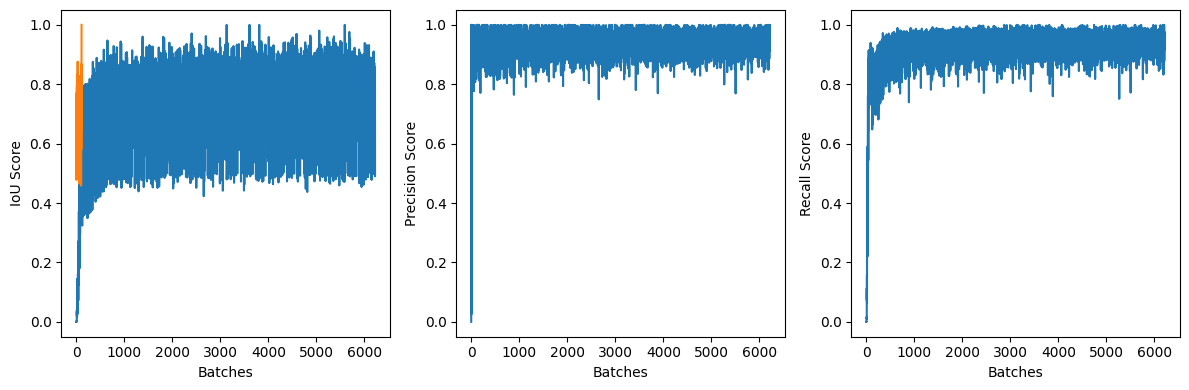

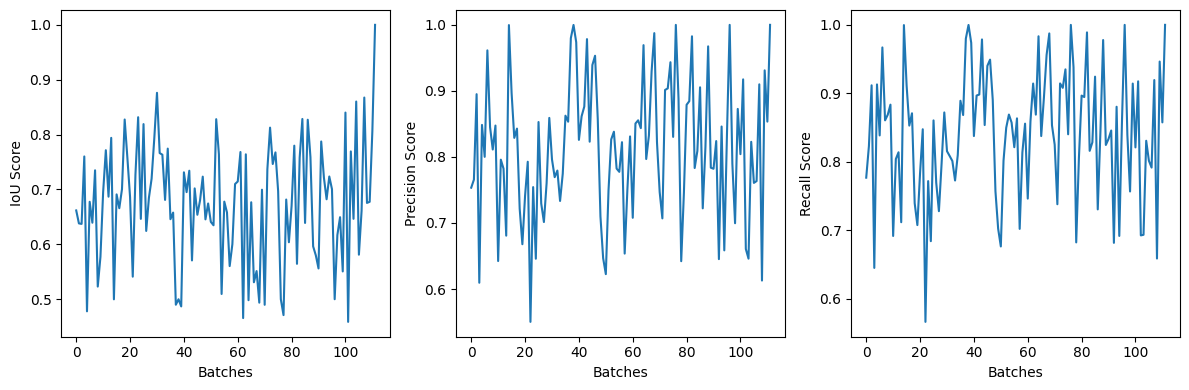

In [ ]:
import matplotlib.pyplot as plt

# Plot IoU, Precision, Recall for training
plt.figure(figsize=(12, 4))
plt.subplot(131)
plt.plot(train_iou_scores, label='Train IoU')
plt.plot(iou_scores, label='Val IoU')
plt.xlabel('Batches')
plt.ylabel('IoU Score')
plt.subplot(132)
plt.plot(train_precision_scores, label='Train Precision')
plt.xlabel('Batches')
plt.ylabel('Precision Score')
plt.subplot(133)
plt.plot(train_recall_scores, label='Train Recall')
plt.xlabel('Batches')
plt.ylabel('Recall Score')
plt.tight_layout()
plt.show()

# Plot IoU, Precision, Recall for validation
plt.figure(figsize=(12, 4))
plt.subplot(131)
plt.plot(iou_scores, label='Val IoU')
plt.xlabel('Batches')
plt.ylabel('IoU Score')
plt.subplot(132)
plt.plot(precision_scores, label='Val Precision')
plt.xlabel('Batches')
plt.ylabel('Precision Score')
plt.subplot(133)
plt.plot(recall_scores, label='Val Recall')
plt.xlabel('Batches')
plt.ylabel('Recall Score')
plt.tight_layout()
plt.show()


In [ ]:
# Save best model
model_save_name = 'best_deeplabv3_resnet50.pth'
path = F"/content/drive/MyDrive/{model_save_name}" 

torch.save({
            'model_state_dict': best_model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'epoch': epoch,
            }, path)

### ResNet50 + FCN (Baseline):

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import ParameterGrid
import torchvision.models as models
from torchvision.models.segmentation import fcn_resnet50

from tqdm import tqdm

from torch.optim.lr_scheduler import StepLR
import time

# get all image names from all 12 classes
def get_img_names(img_folder):
    img_names = []
    for class_folder in os.listdir(img_folder):
        class_folder_path = os.path.join(img_folder, class_folder)
        if os.path.isdir(class_folder_path):  # Check if it's a directory
            img_names.extend([os.path.join(class_folder, img) for img in os.listdir(class_folder_path) if img.endswith('.jpg')])
    return img_names

# Define the hyperparameters to tune
param_grid = {
    'batch_size': [8],
    'lr': [5e-5], # tested (not optimal): 1e-3, 1e-5, 5e-4, 2.5e-4, 7.5e-05
    'weight_decay': [0.1] # tested (not optimal): 0, 0.001
}

grid = ParameterGrid(param_grid)

best_iou = 0
best_params = None
best_model = None

for params in grid:
    batch_size = params['batch_size']
    lr = params['lr']
    weight_decay = params['weight_decay']
    
    # Create datasets (full 12 classes)
    img_folder="/content/drive/MyDrive/Pruned_images"
    mask_folder="/content/drive/MyDrive/Whole_masks_datasets"

    # All image names
    img_names = get_img_names(img_folder)

    # Split into train/val/test
    train_img_names, val_test_img_names = train_test_split(img_names, test_size=0.2, random_state=42) # 80% for train, 20% for val+test
    # print(train_img_names)
    val_img_names, test_img_names = train_test_split(val_test_img_names, test_size=0.5, random_state=42) # 10% for val, 10% for test
    # print(val_test_img_names)

    try:
        train_dataset = GarbageSegmentationDataset(img_folder, mask_folder, train_img_names, img_transforms_train, mask_transforms)
    except Exception as e:
        print(f"Error: {e}")
        continue
    try:
        valid_dataset = GarbageSegmentationDataset(img_folder, mask_folder, val_img_names, img_transforms_val_test, mask_transforms)
    except Exception as e:
        print(f"Error: {e}")
        continue

    # Filter out None samples from our data, and only then passes it to PyTorch's default collate function. 
    # Make sure that all corresponding image-mask pairs exist!
    def collate_fn(batch):
        batch = list(filter(lambda x: x is not None, batch))
        if not batch: # if the batch is empty after filtering
            return None
        return torch.utils.data.dataloader.default_collate(batch)


    # In your DataLoader, add the collate_fn argument
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, collate_fn=collate_fn)
    valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=2, collate_fn=collate_fn)

    # Create baseline model (resnet50_FCN)
    def create_baseline_model(num_classes):
        # Create an FCN with a ResNet50 backbone, pre-trained on ImageNet
        model = fcn_resnet50(pretrained=True, progress=True)

        # Replace the classifier with a new one that outputs the correct number of classes
        model.classifier[4] = nn.Conv2d(512, num_classes, kernel_size=(1, 1), stride=(1, 1)) #

        return model

    num_classes = 12
    model = create_baseline_model(num_classes)
    model = model.to(device)

    # Set loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)

    # Learning rate scheduler & stuff
    step_size = 200  # Adjust learning rate every 200 batches
    scheduler = StepLR(optimizer, step_size=step_size, gamma=0.1)
    counter = 0

    # Define early stopping parameters
    patience = 5  # How many epochs we will wait for the validation score to improve
    epochs_no_improve = 0  # Counter for epochs without improvement
    best_val_score = 0  # Best validation score seen so far

    # For plotting.
    train_iou_scores0 = []
    train_precision_scores0 = []
    train_recall_scores0 = []

    # Training Loop
    num_epochs = 7
    for epoch in range(num_epochs):
    # for epoch in tqdm(range(num_epochs), desc='Training Epochs', leave=False):
        model.train()
        num_samples = 0 #

        # for images, masks in train_loader: (I had error here)
        # for batch in train_loader:
        for batch in tqdm(train_loader, desc='Training Batches', leave=False):
            if batch is None:
                print("the batch is None:()")
                continue
            images, masks = batch
            
            num_samples += images.size(0) # add the batch size to the total count


            # Move tensors to the configured device
            images = images.to(device)
            masks = masks.to(device)

            # Forward pass
            outputs = model(images)['out'] # will output a 12-channel image where each channel represents the predicted probabilities for a particular class.
            
            masks = masks.squeeze(1) # squeeze the unnecessary dimension (the dimension at index 1 
                                     # is always 1 since masks are in the grey scale. But we don't need it in Cross-Entropy Loss)) # Test this.
            
            loss = criterion(outputs, masks)

            ### IOU.
            iou = iou_score_12(outputs, masks)
            ### IOU.

            ### Precision & Recall.
            precision = precision_score(outputs, masks)
            recall = recall_score(outputs, masks)
            # print('Train Precision: {}, Train Recall: {}'.format(precision, recall))
            train_iou_scores0.append(iou)
            train_precision_scores0.append(precision)
            train_recall_scores0.append(recall)
            ### Precision & Recall.

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            counter += 1
            if counter % step_size == 0:
                scheduler.step()

        print(f'Number of valid samples in epoch {epoch+1}: {num_samples}')


        # Validation Loop
        model.eval()
        
        # For plotting.
        iou_scores0 = []
        precision_scores0 = []
        recall_scores0 = []
        num_samples = 0 #
        elapsed_time = 0  # For FPS calculation

        with torch.no_grad():
            for images, masks in valid_loader:
                num_samples += images.size(0) # add the batch size to the total count

                images = images.to(device)
                masks = masks.to(device)
                
                # Time the forward pass for FPS calculation	
                start_time = time.time()	
                outputs = model(images)['out'] # Perform inference once	
                elapsed_time += time.time() - start_time

                # IOU.
                iou = iou_score_12(outputs, masks) #
                iou_scores0.append(iou)
                # IOU.

                ### Precision & Recall.
                precision = precision_score(outputs, masks)
                recall = recall_score(outputs, masks)
                precision_scores0.append(precision)
                recall_scores0.append(recall)
                ### Precision & Recall.

            print(f'Number of valid samples in validation set: {num_samples}')

        avg_iou = np.mean(iou_scores0)
        avg_precision = np.mean(precision_scores0)
        avg_recall = np.mean(recall_scores0)
        print('Parameters:', params)
        print('Average IoU score on validation set:', avg_iou)
        print('Average Precision score on validation set:', avg_precision)
        print('Average Recall score on validation set:', avg_recall)
        # Compute FPS	
        fps = num_samples / elapsed_time	
        print('Average FPS on validation set:', fps)
        
        if avg_iou > best_iou:
            best_iou = avg_iou
            best_params = params
            best_model = model
            epochs_no_improve = 0  # Reset counter
        else:
            epochs_no_improve += 1  # Increment counter
            if epochs_no_improve == patience:
                print('Early stopping triggered')
                break  # Exit the loop (i.e. start the next epoch)
print('Best parameters:', best_params)

Number of valid samples in epoch 1: 7109


Number of valid samples in validation set: 889
Parameters: {'batch_size': 8, 'lr': 5e-05, 'weight_decay': 0.1}
Average IoU score on validation set: 0.7734917508148426
Average Precision score on validation set: 0.8135820686021545
Average Recall score on validation set: 0.7970621092326439
Average FPS on validation set: 1017.7565236284154


Number of valid samples in epoch 2: 7109


Number of valid samples in validation set: 889
Parameters: {'batch_size': 8, 'lr': 5e-05, 'weight_decay': 0.1}
Average IoU score on validation set: 0.780521597764752
Average Precision score on validation set: 0.8108334184404457
Average Recall score on validation set: 0.8097287447737536
Average FPS on validation set: 1018.8149150408375


Number of valid samples in epoch 3: 7109


Number of valid samples in validation set: 889
Parameters: {'batch_size': 8, 'lr': 5e-05, 'weight_decay': 0.1}
Average IoU score on validation set: 0.8011494645422493
Average Precision score on validation set: 0.8129200261346297
Average Recall score on validation set: 0.8038694809894172
Average FPS on validation set: 996.7364545589417


Number of valid samples in epoch 4: 7109


Number of valid samples in validation set: 889
Parameters: {'batch_size': 8, 'lr': 5e-05, 'weight_decay': 0.1}
Average IoU score on validation set: 0.6321308886266154
Average Precision score on validation set: 0.8132874044545491
Average Recall score on validation set: 0.8508689090739882
Average FPS on validation set: 1027.6051677672383


Number of valid samples in epoch 5: 7109


Number of valid samples in validation set: 889
Parameters: {'batch_size': 8, 'lr': 5e-05, 'weight_decay': 0.1}
Average IoU score on validation set: 0.7981259644153093
Average Precision score on validation set: 0.8126093749129787
Average Recall score on validation set: 0.8093266056160885
Average FPS on validation set: 1028.4537641615468


Number of valid samples in epoch 6: 7109


Number of valid samples in validation set: 889
Parameters: {'batch_size': 8, 'lr': 5e-05, 'weight_decay': 0.1}
Average IoU score on validation set: 0.4495445851126368
Average Precision score on validation set: 0.8363686528800477
Average Recall score on validation set: 0.8744890529977337
Average FPS on validation set: 1021.8014123176747


Number of valid samples in epoch 7: 7109


Number of valid samples in validation set: 889
Parameters: {'batch_size': 8, 'lr': 5e-05, 'weight_decay': 0.1}
Average IoU score on validation set: 0.7907194645119523
Average Precision score on validation set: 0.812716833632478
Average Recall score on validation set: 0.8063206519746918
Average FPS on validation set: 1016.0761361632879
Best parameters: {'batch_size': 8, 'lr': 5e-05, 'weight_decay': 0.1}


In [ ]:
# Save best model
model_save_name = 'best_baseline.pth'
path = F"/content/drive/MyDrive/{model_save_name}" 

torch.save({
            'model_state_dict': best_model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'epoch': epoch,
            }, path)

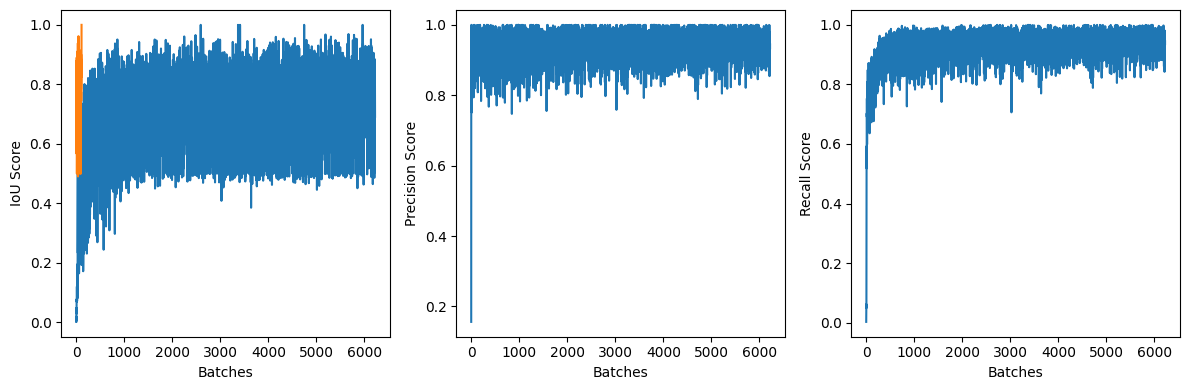

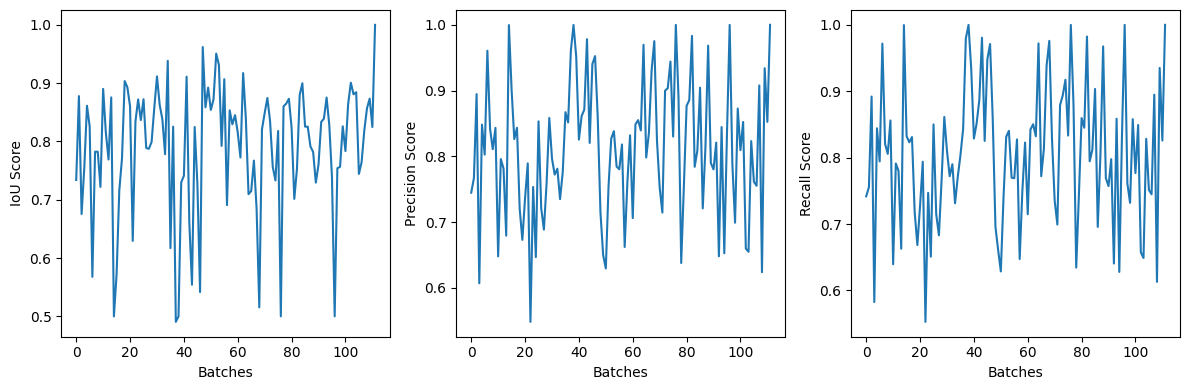

In [ ]:
import matplotlib.pyplot as plt

# Plot IoU, Precision, Recall for training
plt.figure(figsize=(12, 4))
plt.subplot(131)
plt.plot(train_iou_scores0, label='Train IoU')
plt.plot(iou_scores0, label='Val IoU')
plt.xlabel('Batches')
plt.ylabel('IoU Score')
plt.subplot(132)
plt.plot(train_precision_scores0, label='Train Precision')
plt.xlabel('Batches')
plt.ylabel('Precision Score')
plt.subplot(133)
plt.plot(train_recall_scores0, label='Train Recall')
plt.xlabel('Batches')
plt.ylabel('Recall Score')
plt.tight_layout()
plt.show()

# Plot IoU, Precision, Recall for validation
plt.figure(figsize=(12, 4))
plt.subplot(131)
plt.plot(iou_scores0, label='Val IoU')
plt.xlabel('Batches')
plt.ylabel('IoU Score')
plt.subplot(132)
plt.plot(precision_scores0, label='Val Precision')
plt.xlabel('Batches')
plt.ylabel('Precision Score')
plt.subplot(133)
plt.plot(recall_scores0, label='Val Recall')
plt.xlabel('Batches')
plt.ylabel('Recall Score')
plt.tight_layout()
plt.show()


### MobileNetV3 + DeepLabv3 (Head #2):

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import ParameterGrid
import torchvision.models as models
from torchvision.models.segmentation import deeplabv3_mobilenet_v3_large
import os


from tqdm import tqdm

from torch.optim.lr_scheduler import StepLR
import time

# # get all image names from all 12 classes (for single class)
# def get_img_names(img_folder):
#     img_names = []
#     for item in os.listdir(img_folder):
#         item_path = os.path.join(img_folder, item)
#         if os.path.isdir(item_path):  # Check if it's a directory
#             img_names.extend([os.path.join(item, img) for img in os.listdir(item_path) if img.endswith('.jpg')])
#         elif os.path.isfile(item_path) and item_path.endswith('.jpg'):  # Check if it's a file and ends with .jpg
#             img_names.append(item_path)
#     return img_names

# get all image names from all 12 classes
def get_img_names(img_folder):
    img_names = []
    for class_folder in os.listdir(img_folder):
        class_folder_path = os.path.join(img_folder, class_folder)
        if os.path.isdir(class_folder_path):  # Check if it's a directory
            img_names.extend([os.path.join(class_folder, img) for img in os.listdir(class_folder_path) if img.endswith('.jpg')])
    return img_names


# Define the hyperparameters to tune
param_grid = {
    'batch_size': [8],
    'lr': [1e-4], # tested (not optimal): 1e-3, 1e-5, 5e-4, 2.5e-4, 7.5e-05
    'weight_decay': [0.1] # tested (not optimal): 0, 0.001
}

grid = ParameterGrid(param_grid)

# Grid search
best_iou = 0
best_params = None
best_model = None

for params in grid:
    batch_size = params['batch_size']
    lr = params['lr']
    weight_decay = params['weight_decay']
    
    # Create datasets (full 12 classes)
    img_folder="/content/drive/MyDrive/Pruned_images/"
    mask_folder="/content/drive/MyDrive/Whole_masks_datasets/"

    img_names = get_img_names(img_folder)

    # Split into train/val/test
    train_img_names, val_test_img_names = train_test_split(img_names, test_size=0.2, random_state=42) # 80% for train, 20% for val+test
    # print(train_img_names)
    val_img_names, test_img_names = train_test_split(val_test_img_names, test_size=0.5, random_state=42) # 10% for val, 10% for test
    # print(val_test_img_names)

    try:
        train_dataset = GarbageSegmentationDataset(img_folder, mask_folder, train_img_names, img_transforms_train, mask_transforms)
    except Exception as e:
        print(f"Error: {e}")
        continue
    try:
        valid_dataset = GarbageSegmentationDataset(img_folder, mask_folder, val_img_names, img_transforms_val_test, mask_transforms)
    except Exception as e:
        print(f"Error: {e}")
        continue
    
    # Filter out None samples from our data, and only then passes it to PyTorch's default collate function. 
    # Make sure that all corresponding image-mask pairs exist!
    def collate_fn(batch):
        batch = list(filter(lambda x: x is not None, batch))
        if not batch: # if the batch is empty after filtering
            return None
        return torch.utils.data.dataloader.default_collate(batch)


    # In your DataLoader, add the collate_fn argument
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, collate_fn=collate_fn)
    valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=2, collate_fn=collate_fn)


    # Create our model-3 (deeplabv3_resnet50)
    model = deeplabv3_mobilenet_v3_large(pretrained=True, progress=False)
    num_classes = 12 # we have 12 garbage classes
    model.classifier[4] = nn.Conv2d(in_channels=256, out_channels=num_classes, kernel_size=(1, 1), stride=(1, 1))
    model = model.to(device)

    # Set loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)

    # Learning rate scheduler & stuff
    step_size = 200  # Adjust learning rate every 200 batches
    scheduler = StepLR(optimizer, step_size=step_size, gamma=0.1)
    counter = 0

    # Define early stopping parameters
    patience = 5  # How many batches we will wait for the validation score to improve
    epochs_no_improve = 0  # Counter for epochs without improvement
    best_val_score = 0  # Best validation score seen so far

    # For plotting.
    train_iou_scores = []
    train_precision_scores = []
    train_recall_scores = []

    # Training Loop
    num_epochs = 7
    for epoch in range(num_epochs):
    # for epoch in tqdm(range(num_epochs), desc='Training Epochs', leave=False):
        model.train()
        num_samples = 0 #

        # for images, masks in train_loader: (I had error here)
        # for batch in train_loader:
        for batch in tqdm(train_loader, desc='Training Batches', leave=False):
            if batch is None:
                print("the batch is None:()")
                continue
            images, masks = batch
            
            num_samples += images.size(0) # add the batch size to the total count


            # Move tensors to the configured device
            images = images.to(device)
            masks = masks.to(device)

            # start_time = time.time() #
            # Forward pass
            outputs = model(images)['out'] # will output a 12-channel image where each channel represents the predicted probabilities for a particular class.
            # print(time.time() - start_time)
            
            masks = masks.squeeze(1) # squeeze the unnecessary dimension (the dimension at index 1 
                                     # is always 1 since masks are in the grey scale. But we don't need it in Cross-Entropy Loss)) # Test this.
            
            loss = criterion(outputs, masks)

            ### IOU.
            iou = iou_score_12(outputs, masks)
            ### IOU.

            ### Precision & Recall.
            precision = precision_score(outputs, masks)
            recall = recall_score(outputs, masks)
            # print('Train Precision: {}, Train Recall: {}'.format(precision, recall))
            train_iou_scores.append(iou)
            train_precision_scores.append(precision)
            train_recall_scores.append(recall)
            ### Precision & Recall.

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            counter += 1
            if counter % step_size == 0:
                scheduler.step()

        print(f'Number of valid samples in epoch {epoch+1}: {num_samples}')


        # Validation Loop (1 per epoch)
        model.eval()
        
        # For plotting.
        iou_scores1 = []
        precision_scores1 = []
        recall_scores1 = []
        num_samples = 0 #
        elapsed_time = 0  # For FPS calculation


        with torch.no_grad():
            for images, masks in valid_loader:
                num_samples += images.size(0) # add the batch size to the total count

                images = images.to(device)
                masks = masks.to(device)

                # Time the forward pass for FPS calculation
                start_time = time.time()
                outputs = model(images)['out'] # Perform inference once
                elapsed_time += time.time() - start_time

                # IOU.
                iou = iou_score_12(outputs, masks) #
                iou_scores1.append(iou)
                # IOU.

                ### Precision & Recall.
                precision = precision_score(outputs, masks)
                recall = recall_score(outputs, masks)
                precision_scores1.append(precision)
                recall_scores1.append(recall)
                ### Precision & Recall.

            print(f'Number of valid samples in validation set: {num_samples}')

        avg_iou = np.mean(iou_scores1)
        avg_precision = np.mean(precision_scores1)
        avg_recall = np.mean(recall_scores1)
        print('Parameters:', params)
        print('Average IoU score on validation set:', avg_iou)
        print('Average Precision score on validation set:', avg_precision)
        print('Average Recall score on validation set:', avg_recall)
        
        # Compute FPS
        fps = num_samples / elapsed_time
        print('Average FPS on validation set:', fps)
        
        if avg_iou > best_iou:
            best_iou = avg_iou
            best_params = params
            best_model = model
            epochs_no_improve = 0  # Reset counter
        else:
            epochs_no_improve += 1  # Increment counter
            if epochs_no_improve == patience:
                print('Early stopping triggered')
                break  # Exit the loop (i.e. start the next epoch)

print('Best parameters:', best_params)
# print('Best Precision score score:', best_iou)
# print('Best Recall score score:', best_iou)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_MobileNet_V3_Large_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_MobileNet_V3_Large_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/deeplabv3_mobilenet_v3_large-fc3c493d.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_mobilenet_v3_large-fc3c493d.pth
                                                                   

Number of valid samples in epoch 1: 7109


Number of valid samples in validation set: 889
Parameters: {'batch_size': 8, 'lr': 0.0001, 'weight_decay': 0.1}
Average IoU score on validation set: 0.7569453940152953
Average Precision score on validation set: 0.8145818041544989
Average Recall score on validation set: 0.7908716340801806
Average FPS on validation set: 765.6720281189276


Number of valid samples in epoch 2: 7109


Number of valid samples in validation set: 889
Parameters: {'batch_size': 8, 'lr': 0.0001, 'weight_decay': 0.1}
Average IoU score on validation set: 0.7590472684210979
Average Precision score on validation set: 0.8146842502827419
Average Recall score on validation set: 0.8102521423695735
Average FPS on validation set: 860.2809240841248


Number of valid samples in epoch 3: 7109


Number of valid samples in validation set: 889
Parameters: {'batch_size': 8, 'lr': 0.0001, 'weight_decay': 0.1}
Average IoU score on validation set: 0.7617588272787742
Average Precision score on validation set: 0.8122443527858448
Average Recall score on validation set: 0.8084938394084963
Average FPS on validation set: 856.7413485175764


Number of valid samples in epoch 4: 7109


Number of valid samples in validation set: 889
Parameters: {'batch_size': 8, 'lr': 0.0001, 'weight_decay': 0.1}
Average IoU score on validation set: 0.7719580897632107
Average Precision score on validation set: 0.8140985126749369
Average Recall score on validation set: 0.8143525415537309
Average FPS on validation set: 860.5171813288026


Number of valid samples in epoch 5: 7109


Number of valid samples in validation set: 889
Parameters: {'batch_size': 8, 'lr': 0.0001, 'weight_decay': 0.1}
Average IoU score on validation set: 0.7777873473719309
Average Precision score on validation set: 0.8121227957622912
Average Recall score on validation set: 0.7939632237826423
Average FPS on validation set: 859.6076085149822


Number of valid samples in epoch 6: 7109


Number of valid samples in validation set: 889
Parameters: {'batch_size': 8, 'lr': 0.0001, 'weight_decay': 0.1}
Average IoU score on validation set: 0.7815302751468965
Average Precision score on validation set: 0.8118251277085119
Average Recall score on validation set: 0.7933814045986699
Average FPS on validation set: 845.2401286469851


Number of valid samples in epoch 7: 7109


Number of valid samples in validation set: 889
Parameters: {'batch_size': 8, 'lr': 0.0001, 'weight_decay': 0.1}
Average IoU score on validation set: 0.7865479168819586
Average Precision score on validation set: 0.8147407877505702
Average Recall score on validation set: 0.8111987656128997
Average FPS on validation set: 835.1977672726703
Best parameters: {'batch_size': 8, 'lr': 0.0001, 'weight_decay': 0.1}


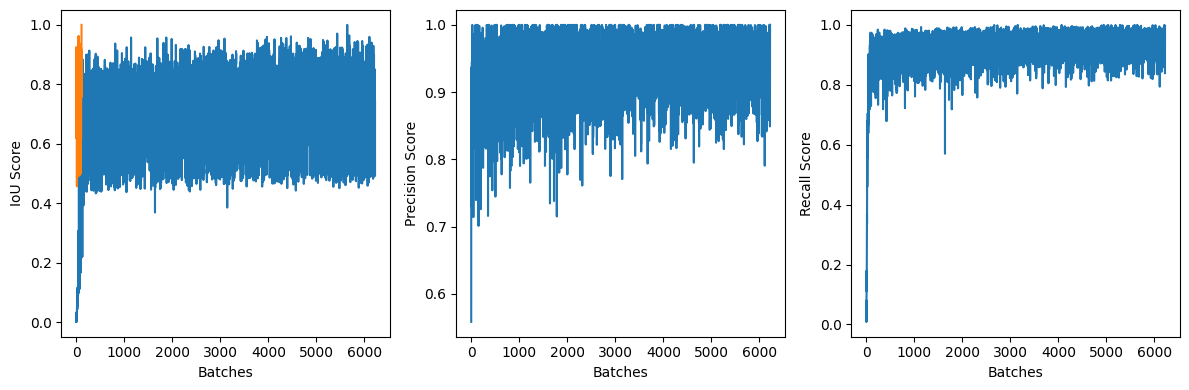

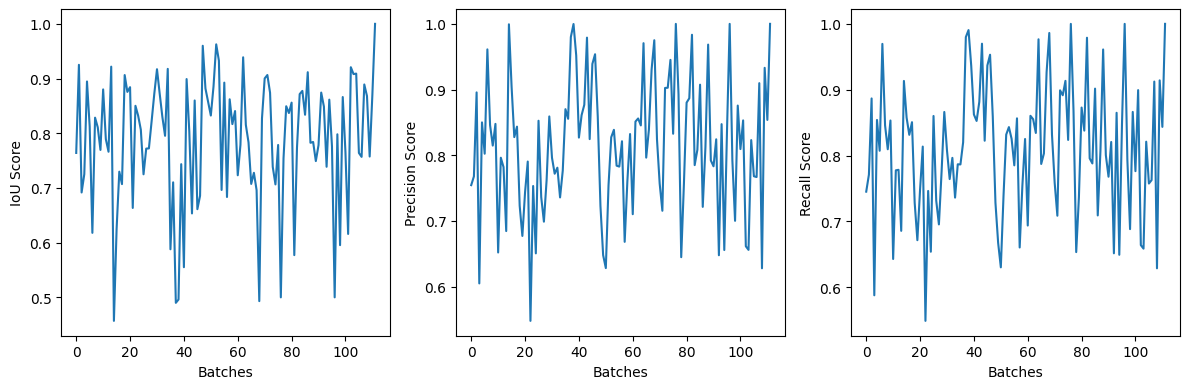

In [ ]:
import matplotlib.pyplot as plt

# Plot IoU, Precision, Recall for training
plt.figure(figsize=(12, 4))
plt.subplot(131)
plt.plot(train_iou_scores, label='Train IoU')
plt.plot(iou_scores1, label='Val IoU')
plt.xlabel('Batches')
plt.ylabel('IoU Score')
plt.subplot(132)
plt.plot(train_precision_scores, label='Train Precision')
plt.xlabel('Batches')
plt.ylabel('Precision Score')
plt.subplot(133)
plt.plot(train_recall_scores, label='Train Recall')
plt.xlabel('Batches')
plt.ylabel('Recall Score')
plt.tight_layout()
plt.show()

# Plot IoU, Precision, Recall for validation
plt.figure(figsize=(12, 4))
plt.subplot(131)
plt.plot(iou_scores1, label='Val IoU')
plt.xlabel('Batches')
plt.ylabel('IoU Score')
plt.subplot(132)
plt.plot(precision_scores1, label='Val Precision')
plt.xlabel('Batches')
plt.ylabel('Precision Score')
plt.subplot(133)
plt.plot(recall_scores1, label='Val Recall')
plt.xlabel('Batches')
plt.ylabel('Recall Score')
plt.tight_layout()
plt.show()


### Save & Reload

**Save & Reload**

In [ ]:
# Save best model
model_save_name = 'best_deeplabv3_mobilenet_v3.pth'
path = F"/content/drive/MyDrive/{model_save_name}" 

torch.save({
            'model_state_dict': best_model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'epoch': epoch,
            }, path)

**Reload**

In [ ]:
# # For future reload.

# from torchvision.models.segmentation import deeplabv3_mobilenet_v3_large
# from torch.optim.lr_scheduler import StepLR

# # Load
# checkpoint = torch.load("/content/drive/MyDrive/best_deeplabv3_mobilenet_v3.pth") #

# # model = deeplabv3_mobilenet_v3_large(pretrained=False) # NOTE: If we set pretrained=True, the model will be instantiated with weights that have been pre-trained on ImageNet :(
# model = deeplabv3_mobilenet_v3_large(pretrained=False, aux_loss=True)

# # Make sure to match the output channels
# num_classes = 12
# model.classifier[4] = nn.Conv2d(in_channels=256, out_channels=num_classes, kernel_size=(1, 1), stride=(1, 1))

# model.load_state_dict(checkpoint['model_state_dict'])
# model = model.to(device)

# optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)  # make sure to use the same parameters
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

# scheduler = StepLR(optimizer, step_size=100, gamma=0.1)  # again, same parameters
# scheduler.load_state_dict(checkpoint['scheduler_state_dict'])

# epoch = checkpoint['epoch']

# # Then you can continue your training loop from `epoch`


### Final Plot:

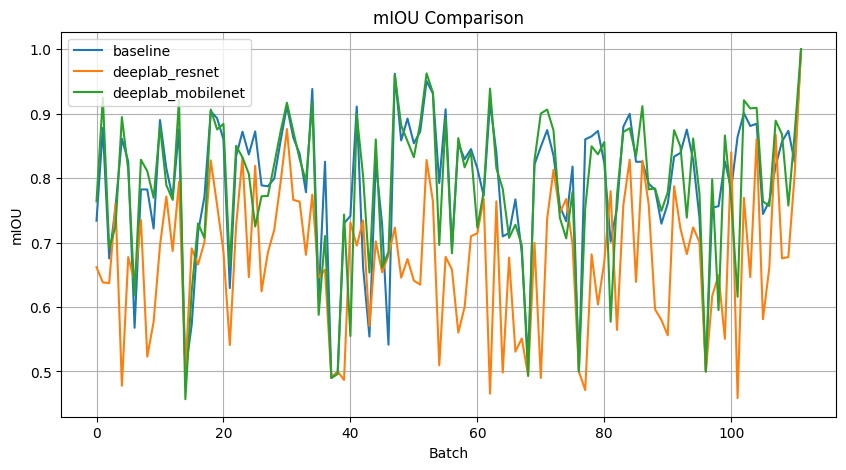

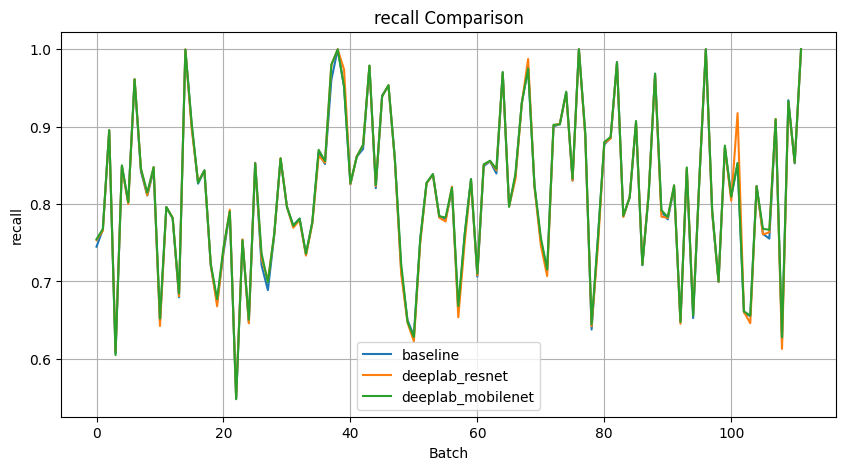

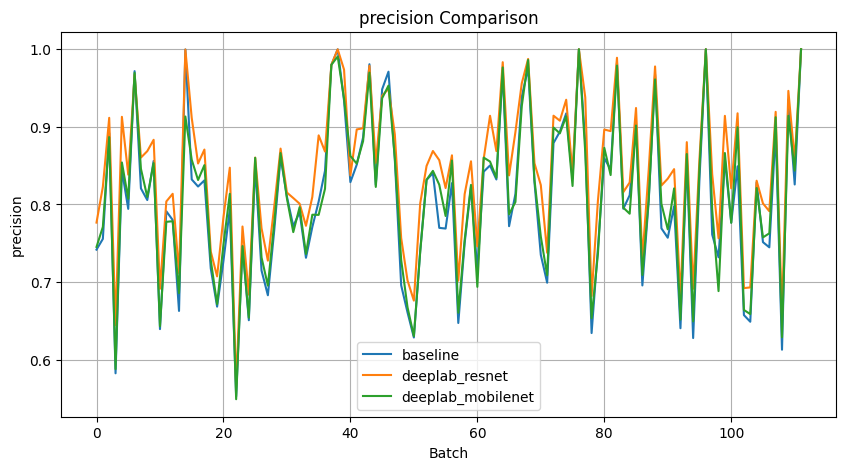

In [ ]:
import matplotlib.pyplot as plt

# Assuming metrics_dict is a dictionary where the key is the model name and the value is another dictionary.
# This inner dictionary should have keys as the metric names and values as lists containing the metric value at each batch or epoch.

metrics_dict = {
    "baseline": {
        "mIOU": iou_scores0,
        "recall": precision_scores0,
        "precision": recall_scores0
    },
    "deeplab_resnet": {
        "mIOU": iou_scores,
        "recall": precision_scores,
        "precision": recall_scores
    },
    "deeplab_mobilenet": {
        "mIOU": iou_scores1,
        "recall": precision_scores1,
        "precision": recall_scores1
    }
}

metrics_list = ["mIOU", "recall", "precision"]

for metric in metrics_list:
    plt.figure(figsize=(10, 5))
    for model_name, metrics in metrics_dict.items():
        plt.plot(metrics[metric], label=model_name)
        
    plt.title(f"{metric} Comparison")
    plt.xlabel('Batch' if 'each batch' else 'Epoch')
    plt.ylabel(metric)
    plt.legend()
    plt.grid(True)
    plt.show()



### Final Evaluation:

In [ ]:
try:
    test_dataset = GarbageSegmentationDataset(img_folder, mask_folder, test_img_names, img_transforms_val_test, mask_transforms)
except Exception as e:
    print(f"Error: {e}")

test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2, collate_fn=collate_fn)

In [ ]:
model.eval()
iou_scores = []
with torch.no_grad():
    for images, masks in test_loader:
        images = images.to(device)
        masks = masks.to(device)
        outputs = model(images)['out']
        iou = iou_score_12(outputs, masks)
        iou_scores.append(iou)

print('Average IoU score on test set:', np.mean(iou_scores))


Average IoU score on test set: 0.7911856185659831
